### Import the necessary libraries

In [12]:
# IMPORT LIBRARIES AND PACKAGES
import tensorflow as tf
import csv
import numpy as np
import pandas as pd
from PIL import Image

from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon

### Load the training data from train.csv file

In [13]:
trainds= pd.read_csv("train_labels.csv")

### Print the shape of the train dataset

In [14]:
len(trainds)

173

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [15]:
# SETTINGS

ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_SIZE = 128 # MobileNet takes images of size 128*128*3 

EPOCHS = 10 # Number of epochs. I got decent performance with just 5.
BATCH_SIZE = 32 # Depends on your GPU or CPU RAM.

TRAIN_CSV = "train_labels.csv"


trainds.drop('class', axis=1)  
trainds.columns

Index(['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'], dtype='object')

### With the help of csvr.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [16]:
import csv
from PIL import Image
paths = []
coords = np.zeros((trainds.shape[0], 4))
for i in range(len(trainds)):
     path = "C:/Users/Ashwin Narayanan/Documents/GL/Residency9/Internal Lab/images/images/" + trainds.iloc[i,0]
     image_width = trainds.iloc[i,1]
     image_height = trainds.iloc[i,2]
     x0 = trainds.iloc[i,4]
     y0 = trainds.iloc[i,5]
     x1 = trainds.iloc[i,6]
     y1 = trainds.iloc[i,7]
     coords[i, 0] =  x0 * IMAGE_SIZE / image_width # Normalize bounding box by image size
     coords[i, 1] = y0 * IMAGE_SIZE / image_height # Normalize bounding box by image size
     coords[i, 2] = (x1 - x0) * IMAGE_SIZE / image_width # Normalize bounding box by image size
     coords[i, 3] = (y1 - y0) * IMAGE_SIZE / image_height
     paths.append(path)

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [17]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
    img = Image.open(f) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [18]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)


17227776/17225924 [==============================] - 67s 4us/step


### Define a custom loss function IoU which calculates Intersection Over Union

In [19]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [20]:
gt = coords
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE

#checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", verbose=1, save_best_only=True,
#                              save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
#stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
#reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve

model.fit(batch_images,gt,
            epochs=30,batch_size = 32,
            verbose=1)

Epoch 1/30
173/173 [==============================] - 21s 118ms/step - loss: 2773.0830 - IoU: 0.0846
Epoch 2/30
173/173 [==============================] - 17s 96ms/step - loss: 614.7326 - IoU: 0.4410
Epoch 3/30
173/173 [==============================] - 16s 95ms/step - loss: 671.6480 - IoU: 0.5333
Epoch 4/30
173/173 [==============================] - 17s 97ms/step - loss: 582.7552 - IoU: 0.5333
Epoch 5/30
173/173 [==============================] - 17s 97ms/step - loss: 341.3578 - IoU: 0.5798
Epoch 6/30
173/173 [==============================] - 17s 98ms/step - loss: 280.7936 - IoU: 0.5785
Epoch 7/30
173/173 [==============================] - 16s 95ms/step - loss: 246.3862 - IoU: 0.6001
Epoch 8/30
173/173 [==============================] - 17s 95ms/step - loss: 191.5930 - IoU: 0.6636
Epoch 9/30
173/173 [==============================] - 16s 95ms/step - loss: 164.7891 - IoU: 0.7011
Epoch 10/30
173/173 [==============================] - 17s 97ms/step - loss: 148.8919 - IoU: 0.7181
Epoch 1

### Pick a test image from the given data

In [22]:
import cv2
filename = 'C:/Users/Ashwin Narayanan/Documents/GL/Residency9/Internal Lab/images/images/raccoon-15.jpg'
unscaled = cv2.imread(filename) # Original image for display

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [23]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [25]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

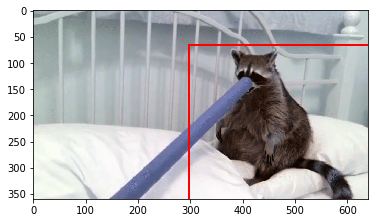

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

## Problem 2 : Time Series Analysis using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temperature values to "Temperature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temperature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

### Import required libraries

In [28]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import pandas as pd 
import tensorflow as tf
import numpy as np

#### Mount google drive

### Load the  data file

In [29]:
df = pd.read_csv('daily-minimum-temperatures-in-me.csv', index_col='Date')
print(df.head())

            Temperature
Date                   
1981-01-01         20.7
1981-01-02         17.9
1981-01-03         18.8
1981-01-04         14.6
1981-01-05         15.8


### Plot the data

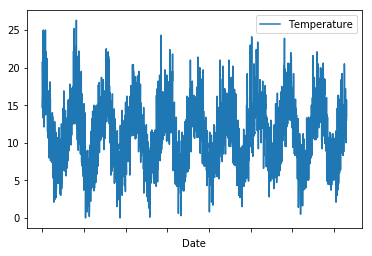

In [30]:
df.plot()

### Check for null values and treat them

In [31]:
df.isnull().sum()

Temperature    0
dtype: int64

#### Drop null values (if any)

In [0]:
# Nothng to drop

### Get the representation of the distribution of data in the form of histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B03E9D30F0>]],
      dtype=object)

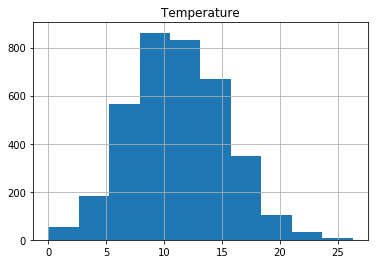

In [32]:
df.hist(bins=10)

### Check the maximum and minimum values

In [33]:
# Scaled Data
print('Min', np.min(df))
print('Max', np.max(df))

Min Temperature    0.0
dtype: float64
Max Temperature    26.3
dtype: float64


### Normalize the data

In [34]:
dataset = df.astype('float32')

### Check the maximum and minimum values of scaled data

In [35]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)

### Split data into Training and Testing set 
<u>Note</u> The train and test data has to be sequential. Keep the first 70% of data in training and the bottom 30% in test data 

In [36]:
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


## Create the sequential data
Map the temperature at a particular time t to the temperature at time t+n, where n is any number you define.

For example: to map temperatures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [37]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print(a)
        print('Y {}'.format(i + look_back))
        print(dataset[i + look_back, 0])
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

### Use function to get training and test set

In [38]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

2555 1
0
X 0 to 1
[0.7870723]
Y 1
0.6806083702582986
1
X 1 to 2
[0.68060837]
Y 2
0.7148288890658444
2
X 2 to 3
[0.71482889]
Y 3
0.5551331104563756
3
X 3 to 4
[0.55513311]
Y 4
0.6007604809535642
4
X 4 to 5
[0.60076048]
Y 5
0.6007604809535642
5
X 5 to 6
[0.60076048]
Y 6
0.6007604809535642
6
X 6 to 7
[0.60076048]
Y 7
0.6615969628626882
7
X 7 to 8
[0.66159696]
Y 8
0.8288973334395067
8
X 8 to 9
[0.82889733]
Y 9
0.7604562958244149
9
X 9 to 10
[0.7604563]
Y 10
0.6159696286268815
10
X 10 to 11
[0.61596963]
Y 11
0.5057034439755123
11
X 11 to 12
[0.50570344]
Y 12
0.6349810360224919
12
X 12 to 13
[0.63498104]
Y 13
0.817490518011246
13
X 13 to 14
[0.81749052]
Y 14
0.9505703697805186
14
X 14 to 15
[0.95057037]
Y 15
0.7870722951873749
15
X 15 to 16
[0.7870723]
Y 16
0.7832699992037001
16
X 16 to 17
[0.78327]
Y 17
0.9429657778131689
17
X 17 to 18
[0.94296578]
Y 18
0.6730038508137127
18
X 18 to 19
[0.67300385]
Y 19
0.5893536292639215
19
X 19 to 20
[0.58935363]
Y 20
0.6920152582093231
20
X 20 to 21
[0.6

227
X 227 to 228
[0.391635]
Y 228
0.3992395553078178
228
X 228 to 229
[0.39923956]
Y 229
0.28897338878713946
229
X 229 to 230
[0.28897339]
Y 230
0.3688212962225648
230
X 230 to 231
[0.3688213]
Y 231
0.4752851848902593
231
X 231 to 232
[0.47528518]
Y 232
0.2813688330811717
232
X 232 to 233
[0.28136883]
Y 233
0.3003802404767821
233
X 233 to 234
[0.30038024]
Y 234
0.1482889813118991
234
X 234 to 235
[0.14828898]
Y 235
0.2509505739959187
235
X 235 to 236
[0.25095057]
Y 236
0.17490494441347723
236
X 236 to 237
[0.17490494]
Y 237
0.26615970353854523
237
X 237 to 238
[0.2661597]
Y 238
0.22813688874732446
238
X 238 to 239
[0.22813689]
Y 239
0.2091254813517141
239
X 239 to 240
[0.20912548]
Y 240
0.30798481431344077
240
X 240 to 241
[0.30798481]
Y 241
0.2091254813517141
241
X 241 to 242
[0.20912548]
Y 242
0.23574144445329223
242
X 242 to 243
[0.23574144]
Y 243
0.30418251832976595
243
X 243 to 244
[0.30418252]
Y 244
0.39163499960185005
244
X 244 to 245
[0.391635]
Y 245
0.3726235922062397
245
X 24

0.5323194070770905
427
X 427 to 428
[0.53231941]
Y 428
0.817490518011246
428
X 428 to 429
[0.81749052]
Y 429
0.7414448884288045
429
X 429 to 430
[0.74144489]
Y 430
0.6349810360224919
430
X 430 to 431
[0.63498104]
Y 431
0.7262357770168689
431
X 431 to 432
[0.72623578]
Y 432
0.4182509627034282
432
X 432 to 433
[0.41825096]
Y 433
0.34220533312098667
433
X 433 to 434
[0.34220533]
Y 434
0.38022814791220744
434
X 434 to 435
[0.38022815]
Y 435
0.5551331104563756
435
X 435 to 436
[0.55513311]
Y 436
0.4752851848902593
436
X 436 to 437
[0.47528518]
Y 437
0.6539924434181024
437
X 437 to 438
[0.65399244]
Y 438
0.7300380730005438
438
X 438 to 439
[0.73003807]
Y 439
0.8441065173742061
439
X 439 to 440
[0.84410652]
Y 440
0.5969581849698893
440
X 440 to 441
[0.59695818]
Y 441
0.5399239627830582
441
X 441 to 442
[0.53992396]
Y 442
0.3726235922062397
442
X 442 to 443
[0.37262359]
Y 443
0.5323194070770905
443
X 443 to 444
[0.53231941]
Y 444
0.665399258846363
444
X 444 to 445
[0.66539926]
Y 445
0.78707229

Y 627
0.15969581487085074
627
X 627 to 628
[0.15969581]
Y 628
0.15209125916488297
628
X 628 to 629
[0.15209126]
Y 629
0.20152092564574633
629
X 629 to 630
[0.20152093]
Y 630
0.23954374043696708
630
X 630 to 631
[0.23954374]
Y 631
0.3231939257253763
631
X 631 to 632
[0.32319393]
Y 632
0.43726237009903857
632
X 632 to 633
[0.43726237]
Y 633
0.29277566664012333
633
X 633 to 634
[0.29277567]
Y 634
0.34980988882695446
634
X 634 to 635
[0.34980989]
Y 635
0.2965779626237982
635
X 635 to 636
[0.29657796]
Y 636
0.23954374043696708
636
X 636 to 637
[0.23954374]
Y 637
0.23954374043696708
637
X 637 to 638
[0.23954374]
Y 638
0.3269962217090512
638
X 638 to 639
[0.32699622]
Y 639
0.23193916660030833
639
X 639 to 640
[0.23193917]
Y 640
0.5019011479918374
640
X 640 to 641
[0.50190115]
Y 641
0.3764258519285326
641
X 641 to 642
[0.37642585]
Y 642
0.1787072222664611
642
X 642 to 643
[0.17870722]
Y 643
0.2205323330413567
643
X 643 to 644
[0.22053233]
Y 644
0.5665399258846363
644
X 644 to 645
[0.56653993]


[0.25475285]
Y 827
0.21673003705768185
827
X 827 to 828
[0.21673004]
Y 828
0.34600762910466154
828
X 828 to 829
[0.34600763]
Y 829
0.5779467775742789
829
X 829 to 830
[0.57794678]
Y 830
0.5893536292639215
830
X 830 to 831
[0.58935363]
Y 831
0.42205325868710303
831
X 831 to 832
[0.42205326]
Y 832
0.4448669258050063
832
X 832 to 833
[0.44486693]
Y 833
0.43726237009903857
833
X 833 to 834
[0.43726237]
Y 834
0.3726235922062397
834
X 834 to 835
[0.37262359]
Y 835
0.23574144445329223
835
X 835 to 836
[0.23574144]
Y 836
0.2547528518489026
836
X 836 to 837
[0.25475285]
Y 837
0.2851711109341556
837
X 837 to 838
[0.28517111]
Y 838
0.3346007774150189
838
X 838 to 839
[0.33460078]
Y 839
0.30418251832976595
839
X 839 to 840
[0.30418252]
Y 840
0.395437259324143
840
X 840 to 841
[0.39543726]
Y 841
0.5513308144727008
841
X 841 to 842
[0.55133081]
Y 842
0.6273764440551423
842
X 842 to 843
[0.62737644]
Y 843
0.5361217030607652
843
X 843 to 844
[0.5361217]
Y 844
0.3992395553078178
844
X 844 to 845
[0.399

X 1026 to 1027
[0.47908748]
Y 1027
0.4904942963021948
1027
X 1027 to 1028
[0.4904943]
Y 1028
0.4448669258050063
1028
X 1028 to 1029
[0.44486693]
Y 1029
0.5323194070770905
1029
X 1029 to 1030
[0.53231941]
Y 1030
0.46768062918429154
1030
X 1030 to 1031
[0.46768063]
Y 1031
0.34220533312098667
1031
X 1031 to 1032
[0.34220533]
Y 1032
0.34980988882695446
1032
X 1032 to 1033
[0.34980989]
Y 1033
0.3726235922062397
1033
X 1033 to 1034
[0.37262359]
Y 1034
0.4486692217886812
1034
X 1034 to 1035
[0.44866922]
Y 1035
0.40304185129149267
1035
X 1035 to 1036
[0.40304185]
Y 1036
0.47908748087393416
1036
X 1036 to 1037
[0.47908748]
Y 1037
0.4182509627034282
1037
X 1037 to 1038
[0.41825096]
Y 1038
0.3117870740357337
1038
X 1038 to 1039
[0.31178707]
Y 1039
0.2851711109341556
1039
X 1039 to 1040
[0.28517111]
Y 1040
0.5171102956651549
1040
X 1040 to 1041
[0.5171103]
Y 1041
0.5627376661623434
1041
X 1041 to 1042
[0.56273767]
Y 1042
0.41444866671975333
1042
X 1042 to 1043
[0.41444867]
Y 1043
0.292775666640123

[0.17490494]
Y 1303
0.24334601828995095
1303
X 1303 to 1304
[0.24334602]
Y 1304
0.3688212962225648
1304
X 1304 to 1305
[0.3688213]
Y 1305
0.26615970353854523
1305
X 1305 to 1306
[0.2661597]
Y 1306
0.38022814791220744
1306
X 1306 to 1307
[0.38022815]
Y 1307
0.40304185129149267
1307
X 1307 to 1308
[0.40304185]
Y 1308
0.43726237009903857
1308
X 1308 to 1309
[0.43726237]
Y 1309
0.3878327036181752
1309
X 1309 to 1310
[0.3878327]
Y 1310
0.42205325868710303
1310
X 1310 to 1311
[0.42205326]
Y 1311
0.4182509627034282
1311
X 1311 to 1312
[0.41825096]
Y 1312
0.33840303713731185
1312
X 1312 to 1313
[0.33840304]
Y 1313
0.3764258519285326
1313
X 1313 to 1314
[0.37642585]
Y 1314
0.4448669258050063
1314
X 1314 to 1315
[0.44486693]
Y 1315
0.4410646660827134
1315
X 1315 to 1316
[0.44106467]
Y 1316
0.34220533312098667
1316
X 1316 to 1317
[0.34220533]
Y 1317
0.23954374043696708
1317
X 1317 to 1318
[0.23954374]
Y 1318
0.3307984814313441
1318
X 1318 to 1319
[0.33079848]
Y 1319
0.3231939257253763
1319
X 1319

0.5019011479918374
1526
X 1526 to 1527
[0.50190115]
Y 1527
0.5779467775742789
1527
X 1527 to 1528
[0.57794678]
Y 1528
0.6311787400388171
1528
X 1528 to 1529
[0.63117874]
Y 1529
0.7984791106156356
1529
X 1529 to 1530
[0.79847911]
Y 1530
0.8517110368187919
1530
X 1530 to 1531
[0.85171104]
Y 1531
0.6463878514507526
1531
X 1531 to 1532
[0.64638785]
Y 1532
0.8250951099785957
1532
X 1532 to 1533
[0.82509511]
Y 1533
0.8136882220275712
1533
X 1533 to 1534
[0.81368822]
Y 1534
0.7072243696212586
1534
X 1534 to 1535
[0.70722437]
Y 1535
0.6159696286268815
1535
X 1535 to 1536
[0.61596963]
Y 1536
0.638783259483403
1536
X 1536 to 1537
[0.63878326]
Y 1537
0.6463878514507526
1537
X 1537 to 1538
[0.64638785]
Y 1538
0.6996197776539089
1538
X 1538 to 1539
[0.69961978]
Y 1539
0.6539924434181024
1539
X 1539 to 1540
[0.65399244]
Y 1540
0.6996197776539089
1540
X 1540 to 1541
[0.69961978]
Y 1541
0.7148288890658444
1541
X 1541 to 1542
[0.71482889]
Y 1542
0.6273764440551423
1542
X 1542 to 1543
[0.62737644]
Y 154

Y 1726
0.4410646660827134
1726
X 1726 to 1727
[0.44106467]
Y 1727
0.4980988882695445
1727
X 1727 to 1728
[0.49809889]
Y 1728
0.2547528518489026
1728
X 1728 to 1729
[0.25475285]
Y 1729
0.24714829614293482
1729
X 1729 to 1730
[0.2471483]
Y 1730
0.29277566664012333
1730
X 1730 to 1731
[0.29277567]
Y 1731
0.3307984814313441
1731
X 1731 to 1732
[0.33079848]
Y 1732
0.273764259244513
1732
X 1732 to 1733
[0.27376426]
Y 1733
0.3992395553078178
1733
X 1733 to 1734
[0.39923956]
Y 1734
0.3269962217090512
1734
X 1734 to 1735
[0.32699622]
Y 1735
0.273764259244513
1735
X 1735 to 1736
[0.27376426]
Y 1736
0.4334600741153637
1736
X 1736 to 1737
[0.43346007]
Y 1737
0.6159696286268815
1737
X 1737 to 1738
[0.61596963]
Y 1738
0.23193916660030833
1738
X 1738 to 1739
[0.23193917]
Y 1739
0.3650190365002719
1739
X 1739 to 1740
[0.36501904]
Y 1740
0.42205325868710303
1740
X 1740 to 1741
[0.42205326]
Y 1741
0.5171102956651549
1741
X 1741 to 1742
[0.5171103]
Y 1742
0.4068441110137856
1742
X 1742 to 1743
[0.4068441

[0.53992396]
Y 1926
0.46387833320061667
1926
X 1926 to 1927
[0.46387833]
Y 1927
0.34220533312098667
1927
X 1927 to 1928
[0.34220533]
Y 1928
0.46768062918429154
1928
X 1928 to 1929
[0.46768063]
Y 1929
0.7490494803961542
1929
X 1929 to 1930
[0.74904948]
Y 1930
0.4866920365799019
1930
X 1930 to 1931
[0.48669204]
Y 1931
0.47148288890658446
1931
X 1931 to 1932
[0.47148289]
Y 1932
0.4562737774946489
1932
X 1932 to 1933
[0.45627378]
Y 1933
0.4562737774946489
1933
X 1933 to 1934
[0.45627378]
Y 1934
0.42205325868710303
1934
X 1934 to 1935
[0.42205326]
Y 1935
0.4828897405962271
1935
X 1935 to 1936
[0.48288974]
Y 1936
0.5399239627830582
1936
X 1936 to 1937
[0.53992396]
Y 1937
0.4410646660827134
1937
X 1937 to 1938
[0.44106467]
Y 1938
0.4562737774946489
1938
X 1938 to 1939
[0.45627378]
Y 1939
0.43726237009903857
1939
X 1939 to 1940
[0.43726237]
Y 1940
0.31558937001940857
1940
X 1940 to 1941
[0.31558937]
Y 1941
0.3992395553078178
1941
X 1941 to 1942
[0.39923956]
Y 1942
0.34220533312098667
1942
X 19

X 2125 to 2126
[0.27376426]
Y 2126
0.4068441110137856
2126
X 2126 to 2127
[0.40684411]
Y 2127
0.4980988882695445
2127
X 2127 to 2128
[0.49809889]
Y 2128
0.5285171110934156
2128
X 2128 to 2129
[0.52851711]
Y 2129
0.4106464069974604
2129
X 2129 to 2130
[0.41064641]
Y 2130
0.395437259324143
2130
X 2130 to 2131
[0.39543726]
Y 2131
0.34600762910466154
2131
X 2131 to 2132
[0.34600763]
Y 2132
0.6083650366595319
2132
X 2132 to 2133
[0.60836504]
Y 2133
0.7984791106156356
2133
X 2133 to 2134
[0.79847911]
Y 2134
0.6159696286268815
2134
X 2134 to 2135
[0.61596963]
Y 2135
0.3269962217090512
2135
X 2135 to 2136
[0.32699622]
Y 2136
0.34980988882695446
2136
X 2136 to 2137
[0.34980989]
Y 2137
0.4752851848902593
2137
X 2137 to 2138
[0.47528518]
Y 2138
0.3688212962225648
2138
X 2138 to 2139
[0.3688213]
Y 2139
0.4752851848902593
2139
X 2139 to 2140
[0.47528518]
Y 2140
0.39163499960185005
2140
X 2140 to 2141
[0.391635]
Y 2141
0.4562737774946489
2141
X 2141 to 2142
[0.45627378]
Y 2142
0.4182509627034282
214

2325
X 2325 to 2326
[0.46387833]
Y 2326
0.4486692217886812
2326
X 2326 to 2327
[0.44866922]
Y 2327
0.4068441110137856
2327
X 2327 to 2328
[0.40684411]
Y 2328
0.3878327036181752
2328
X 2328 to 2329
[0.3878327]
Y 2329
0.38022814791220744
2329
X 2329 to 2330
[0.38022815]
Y 2330
0.31558937001940857
2330
X 2330 to 2331
[0.31558937]
Y 2331
0.2509505739959187
2331
X 2331 to 2332
[0.25095057]
Y 2332
0.3612167405165971
2332
X 2332 to 2333
[0.36121674]
Y 2333
0.46768062918429154
2333
X 2333 to 2334
[0.46768063]
Y 2334
0.28897338878713946
2334
X 2334 to 2335
[0.28897339]
Y 2335
0.3536121848106293
2335
X 2335 to 2336
[0.35361218]
Y 2336
0.19011407395610372
2336
X 2336 to 2337
[0.19011407]
Y 2337
0.1634981108545256
2337
X 2337 to 2338
[0.16349811]
Y 2338
0.24334601828995095
2338
X 2338 to 2339
[0.24334602]
Y 2339
0.4106464069974604
2339
X 2339 to 2340
[0.41064641]
Y 2340
0.2965779626237982
2340
X 2340 to 2341
[0.29657796]
Y 2341
0.3231939257253763
2341
X 2341 to 2342
[0.32319393]
Y 2342
0.368821296

2525
X 2525 to 2526
[0.42205326]
Y 2526
0.3117870740357337
2526
X 2526 to 2527
[0.31178707]
Y 2527
0.3574144445329222
2527
X 2527 to 2528
[0.35741444]
Y 2528
0.4828897405962271
2528
X 2528 to 2529
[0.48288974]
Y 2529
0.4410646660827134
2529
X 2529 to 2530
[0.44106467]
Y 2530
0.4182509627034282
2530
X 2530 to 2531
[0.41825096]
Y 2531
0.42965781439307077
2531
X 2531 to 2532
[0.42965781]
Y 2532
0.5095057036978052
2532
X 2532 to 2533
[0.5095057]
Y 2533
0.5665399258846363
2533
X 2533 to 2534
[0.56653993]
Y 2534
0.5779467775742789
2534
X 2534 to 2535
[0.57794678]
Y 2535
0.5285171110934156
2535
X 2535 to 2536
[0.52851711]
Y 2536
0.5703422218683112
2536
X 2536 to 2537
[0.57034222]
Y 2537
0.6159696286268815
2537
X 2537 to 2538
[0.61596963]
Y 2538
0.6730038508137127
2538
X 2538 to 2539
[0.67300385]
Y 2539
0.7794677032200252
2539
X 2539 to 2540
[0.7794677]
Y 2540
0.5589353701786686
2540
X 2540 to 2541
[0.55893537]
Y 2541
0.4752851848902593
2541
X 2541 to 2542
[0.47528518]
Y 2542
0.414448666719753

[0.2661597]
Y 172
0.2775665552281878
172
X 172 to 173
[0.27756656]
Y 173
0.3003802404767821
173
X 173 to 174
[0.30038024]
Y 174
0.40304185129149267
174
X 174 to 175
[0.40304185]
Y 175
0.30798481431344077
175
X 175 to 176
[0.30798481]
Y 176
0.2547528518489026
176
X 176 to 177
[0.25475285]
Y 177
0.30418251832976595
177
X 177 to 178
[0.30418252]
Y 178
0.38022814791220744
178
X 178 to 179
[0.38022815]
Y 179
0.2547528518489026
179
X 179 to 180
[0.25475285]
Y 180
0.3574144445329222
180
X 180 to 181
[0.35741444]
Y 181
0.3536121848106293
181
X 181 to 182
[0.35361218]
Y 182
0.22813688874732446
182
X 182 to 183
[0.22813689]
Y 183
0.2205323330413567
183
X 183 to 184
[0.22053233]
Y 184
0.18631179610311985
184
X 184 to 185
[0.1863118]
Y 185
0.19011407395610372
185
X 185 to 186
[0.19011407]
Y 186
0.3193916297417015
186
X 186 to 187
[0.31939163]
Y 187
0.46768062918429154
187
X 187 to 188
[0.46768063]
Y 188
0.49429659228586964
188
X 188 to 189
[0.49429659]
Y 189
0.4334600741153637
189
X 189 to 190
[0.

X 371 to 372
[0.46387833]
Y 372
0.5969581849698893
372
X 372 to 373
[0.59695818]
Y 373
0.6197718520877926
373
X 373 to 374
[0.61977185]
Y 374
0.5171102956651549
374
X 374 to 375
[0.5171103]
Y 375
0.47908748087393416
375
X 375 to 376
[0.47908748]
Y 376
0.5247148513711226
376
X 376 to 377
[0.52471485]
Y 377
0.46007607347832374
377
X 377 to 378
[0.46007607]
Y 378
0.5095057036978052
378
X 378 to 379
[0.5095057]
Y 379
0.6577946668790133
379
X 379 to 380
[0.65779467]
Y 380
0.7376425924451296
380
X 380 to 381
[0.73764259]
Y 381
0.6311787400388171
381
X 381 to 382
[0.63117874]
Y 382
0.5285171110934156
382
X 382 to 383
[0.52851711]
Y 383
0.4980988882695445
383
X 383 to 384
[0.49809889]
Y 384
0.6083650366595319
384
X 384 to 385
[0.60836504]
Y 385
0.5513308144727008
385
X 385 to 386
[0.55133081]
Y 386
0.5703422218683112
386
X 386 to 387
[0.57034222]
Y 387
0.47908748087393416
387
X 387 to 388
[0.47908748]
Y 388
0.4752851848902593
388
X 388 to 389
[0.47528518]
Y 389
0.5779467775742789
389
X 389 to 

571
X 571 to 572
[0.15969581]
Y 572
0.2091254813517141
572
X 572 to 573
[0.20912548]
Y 573
0.34220533312098667
573
X 573 to 574
[0.34220533]
Y 574
0.42585551840939595
574
X 574 to 575
[0.42585552]
Y 575
0.30418251832976595
575
X 575 to 576
[0.30418252]
Y 576
0.28897338878713946
576
X 576 to 577
[0.28897339]
Y 577
0.14068441654058586
577
X 577 to 578
[0.14068442]
Y 578
0.2851711109341556
578
X 578 to 579
[0.28517111]
Y 579
0.30798481431344077
579
X 579 to 580
[0.30798481]
Y 580
0.3193916297417015
580
X 580 to 581
[0.31939163]
Y 581
0.2699619813915291
581
X 581 to 582
[0.26996198]
Y 582
0.28897338878713946
582
X 582 to 583
[0.28897339]
Y 583
0.28897338878713946
583
X 583 to 584
[0.28897339]
Y 584
0.21292775920469798
584
X 584 to 585
[0.21292776]
Y 585
0.26615970353854523
585
X 585 to 586
[0.2661597]
Y 586
0.3992395553078178
586
X 586 to 587
[0.39923956]
Y 587
0.2775665552281878
587
X 587 to 588
[0.27756656]
Y 588
0.2965779626237982
588
X 588 to 589
[0.29657796]
Y 589
0.2205323330413567
5

771
X 771 to 772
[0.59315593]
Y 772
0.5703422218683112
772
X 772 to 773
[0.57034222]
Y 773
0.49429659228586964
773
X 773 to 774
[0.49429659]
Y 774
0.5361217030607652
774
X 774 to 775
[0.5361217]
Y 775
0.6577946668790133
775
X 775 to 776
[0.65779467]
Y 776
0.5969581849698893
776
X 776 to 777
[0.59695818]
Y 777
0.7072243696212586
777
X 777 to 778
[0.70722437]
Y 778
0.4828897405962271
778
X 778 to 779
[0.48288974]
Y 779
0.5323194070770905
779
X 779 to 780
[0.53231941]
Y 780
0.5209125553874479
780
X 780 to 781
[0.52091256]
Y 781
0.6197718520877926
781
X 781 to 782
[0.61977185]
Y 782
0.7604562958244149
782
X 782 to 783
[0.7604563]
Y 783
0.6463878514507526
783
X 783 to 784
[0.64638785]
Y 784
0.5779467775742789
784
X 784 to 785
[0.57794678]
Y 785
0.6273764440551423
785
X 785 to 786
[0.62737644]
Y 786
0.6273764440551423
786
X 786 to 787
[0.62737644]
Y 787
0.6577946668790133
787
X 787 to 788
[0.65779467]
Y 788
0.7262357770168689
788
X 788 to 789
[0.72623578]
Y 789
0.7338402964614549
789
X 789 t

0.3269962217090512
971
X 971 to 972
[0.32699622]
Y 972
0.3003802404767821
972
X 972 to 973
[0.30038024]
Y 973
0.22813688874732446
973
X 973 to 974
[0.22813689]
Y 974
0.3612167405165971
974
X 974 to 975
[0.36121674]
Y 975
0.3269962217090512
975
X 975 to 976
[0.32699622]
Y 976
0.28897338878713946
976
X 976 to 977
[0.28897339]
Y 977
0.395437259324143
977
X 977 to 978
[0.39543726]
Y 978
0.39163499960185005
978
X 978 to 979
[0.391635]
Y 979
0.2851711109341556
979
X 979 to 980
[0.28517111]
Y 980
0.11406844437366223
980
X 980 to 981
[0.11406844]
Y 981
0.20152092564574633
981
X 981 to 982
[0.20152093]
Y 982
0.3992395553078178
982
X 982 to 983
[0.39923956]
Y 983
0.5551331104563756
983
X 983 to 984
[0.55513311]
Y 984
0.47908748087393416
984
X 984 to 985
[0.47908748]
Y 985
0.3726235922062397
985
X 985 to 986
[0.37262359]
Y 986
0.273764259244513
986
X 986 to 987
[0.27376426]
Y 987
0.38403044389588226
987
X 987 to 988
[0.38403044]
Y 988
0.395437259324143
988
X 988 to 989
[0.39543726]
Y 989
0.140684

### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [39]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2553, 1, 1)
(1093, 1, 1)


### Define sequntial model, add LSTM layer and compile the model

In [40]:
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers

batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

### Train the model for 100 epochs with batch size = 1

In [41]:
model.fit(X_train, y_train, epochs=100, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/100
 - 11s - loss: 0.0255
Epoch 2/100
 - 7s - loss: 0.0168
Epoch 3/100
 - 8s - loss: 0.0140
Epoch 4/100
 - 7s - loss: 0.0125
Epoch 5/100
 - 8s - loss: 0.0120
Epoch 6/100
 - 7s - loss: 0.0112
Epoch 7/100
 - 7s - loss: 0.0106
Epoch 8/100
 - 7s - loss: 0.0105
Epoch 9/100
 - 7s - loss: 0.0105
Epoch 10/100
 - 7s - loss: 0.0104
Epoch 11/100
 - 7s - loss: 0.0103
Epoch 12/100
 - 7s - loss: 0.0103
Epoch 13/100
 - 7s - loss: 0.0103
Epoch 14/100
 - 8s - loss: 0.0103
Epoch 15/100
 - 7s - loss: 0.0102
Epoch 16/100
 - 7s - loss: 0.0103
Epoch 17/100
 - 7s - loss: 0.0104
Epoch 18/100
 - 7s - loss: 0.0102
Epoch 19/100
 - 8s - loss: 0.0102
Epoch 20/100
 - 7s - loss: 0.0102
Epoch 21/100
 - 7s - loss: 0.0102
Epoch 22/100
 - 7s - loss: 0.0102
Epoch 23/100
 - 8s - loss: 0.0103
Epoch 24/100
 - 7s - loss: 0.0103
Epoch 25/100
 - 8s - loss: 0.0102
Epoch 26/100
 - 7s - loss: 0.0103
Epoch 27/100
 - 7s - loss: 0.0102
Epoch 28/100
 - 7s - loss: 0.0102
Epoch 29/100
 - 8s - loss: 0.0102
Epoch 30/100
 - 7s - l

### Make Predictions and Evaluate your model

In [42]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)

model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.64 RMSE
Test Score: 2.52 RMSE
